## Introdução

Para este trabalho, decidi recorrer à base de dados do **Transfermarkt**, disponibilizada e atualizada semanalmente no **Kaggle**: [https://www.kaggle.com/datasets/davidcariboo/player-scores](https://www.kaggle.com/datasets/davidcariboo/player-scores).

Esta base de dados foi inicialmente é disponibilizada em formato **CSV** e encontra-se organizada em múltiplas tabelas com diferentes tipos de informação relevante para o contexto futebolístico. Das tabelas disponíveis, as que vou utilizar neste trabalho são as seguintes:

- **`players`**: Contém informação básica sobre jogadores, incluindo nome, nacionalidade, data de nascimento, altura, posição, entre outros dados.
- **`clubs`**: Inclui dados dos clubes, como nome, liga associada e estatísticas relativas aos clubes e plantéis.
- **`transfers`**: Descreve as transferências de jogadores entre clubes, com datas, valores, clubes de origem e destino.

Neste projeto, o objetivo principal é aplicar um modelo de regressão linear para prever o valor monetário pago nas transferências de jogadores de futebol entre clubes. Através da integração de múltiplas fontes de dados, pretende-se construir um conjunto de treino consistente, identificar as variáveis mais relevantes e avaliar o desempenho do modelo com base em métricas apropriadas.

Além disso, importa referir que os dados dos clubes disponíveis no dataset correspondem ao estado atual dos clubes e não à sua situação no momento exato de cada transferência. Apesar desta limitação, o meu objetivo neste trabalho inclui também analisar o impacto que as características do clube comprador podem ter no valor de transferência dos jogadores. Para isso, serão considerados dois cenários distintos:

- **Cenário 1**: Previsão do valor de transferência com base exclusivamente nos dados dos jogadores e da própria transferência.

- **Cenário 2**: Previsão do valor de transferência com base nos dados dos jogadores, transferências e características dos clubes compradores, **apenas para transferências ocorridas na época mais recente**, de forma a minimizar o desfasamento temporal entre os dados do clube e o evento da transferência.

In [328]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from datetime import datetime

Comecei por ler os ficheiros csv de cada tabela.

In [329]:
# Ler CSVs
players = pd.read_csv('/players.csv')
clubs = pd.read_csv('/clubs.csv')
transfers = pd.read_csv('/transfers.csv')

De seguida verifiquei as colunas dos datasets para ver quais podem ser úteis para o trabalho.

In [330]:
print(players.columns)
print(clubs.columns)
print(transfers.columns)

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object')
Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season',
       'filename', 'url'],
      dtype='object')
Index(['player_id', 'transfer_date', 'transfer_season', 'from_club_id',
       'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee',
       'market_value_in_eur', 'playe

Após o carregamento dos datasets individuais, foi necessário integrá-los para construir um único conjunto de dados com toda a informação relevante por transferência. Para isso:

1. Foi feita uma junção (`merge`) entre os datasets `transfers` e `players`, com base no `player_id`, de forma a associar a cada transferência os dados do jogador correspondente.
2. Em seguida, foi feita a junção com o dataset `clubs` para obter as informações do clube de origem da transferência. Para evitar conflitos de nomes de colunas, estas foram renomeadas com o sufixo `_from`.
3. Finalmente, foi feita uma segunda junção com o mesmo dataset `clubs`, desta vez para obter os dados do clube de destino, com as colunas renomeadas com o sufixo `_to`.

Este processo permitiu reunir, numa única tabela, dados detalhados sobre o jogador, o clube de origem, o clube de destino e a própria transferência.


In [331]:
df = transfers.merge(players, on='player_id', how='inner')

# Renomear colunas para o clube de origem
clubs_from = clubs.rename(lambda x: f"{x}_from" if x != 'club_id' else x, axis=1)
df = df.merge(clubs_from, left_on='from_club_id', right_on='club_id', how='left')

# Renomear colunas para o clube de destino
clubs_to = clubs.rename(lambda x: f"{x}_to" if x != 'club_id' else x, axis=1)
df = df.merge(clubs_to, left_on='to_club_id', right_on='club_id', how='left')

Após a junção dos datasets, o DataFrame resultante continha diversas colunas redundantes, irrelevantes ou que não acrescentavam valor preditivo ao modelo. Filtrei aquelas que poderiam trazer valor para a análise em questão.

In [332]:
# Lista de colunas a manter
columns_to_keep = ['transfer_date', 'transfer_fee', 'date_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'market_value_in_eur_y', 'highest_market_value_in_eur', 'domestic_competition_id_from',
'total_market_value_from', 'net_transfer_record_from',
'domestic_competition_id_to', 'total_market_value_to', 'squad_size_to', 'average_age_to', 'foreigners_percentage_to', 'national_team_players_to', 'net_transfer_record_to']

# Filtrar o DataFrame
df = df[columns_to_keep]


As colunas removidas enquadram-se nas seguintes categorias:

- **Identificadores arbitrários e ids**: colunas como `player_id`, `club_id_x`, `club_id_y`, `from_club_id`, `to_club_id`, `current_club_id`, `player_code`, `club_code_from`, `club_code_to` não possuem qualquer significado preditivo direto e introduzem apenas ruído. 

- **Coluna da nacionalidade (`country_of_citizenship`)**: apesar de ser uma variável categórica potencialmente relevante, a sua elevada cardinalidade (número de categorias distintas) implicaria a criação de um número elevado de variáveis dummies após codificação.

- **Nomes próprios, URLs e metadados**: variáveis como `first_name`, `last_name`, `name`, `player_name`, `url`, `image_url`, `filename_from`, `filename_to`, `url_from`, `url_to`, `stadium_name_*`, `coach_name_*` são informativas apenas a nível descritivo e não contribuem para a previsão do valor de transferência.

- **Dados redundantes ou duplicados**: foram eliminadas colunas como `market_value_in_eur_x` (duplicado de outra variável mais atualizada) e `last_season`, `last_season_from`, `last_season_to`, que não acrescentam valor adicional ao modelo.

- **Informação altamente granular**: como `city_of_birth`, `country_of_birth`, cuja variabilidade é extremamente elevada e cuja relação com o valor de transferência é, na maioria dos casos, irrelevante ou indireta.

- **Estatísticas dos clubes de origem**: removidas colunas como `squad_size_from`, `average_age_from`, `foreigners_number_from`, entre outras. Optou-se por manter apenas as estatísticas dos clubes de destino, por se considerar que refletem melhor o contexto de valorização do jogador no momento da transferência.

Este processo de filtragem visou não só reduzir a dimensionalidade do dataset, mas sobretudo eliminar redundâncias e garantir que apenas variáveis potencialmente explicativas são utilizadas na construção do modelo.

Verifiquei as colunas que o df tem após estas alterações.

In [333]:
print(df.columns)

Index(['transfer_date', 'transfer_fee', 'date_of_birth', 'position',
       'sub_position', 'foot', 'height_in_cm', 'market_value_in_eur_y',
       'highest_market_value_in_eur', 'domestic_competition_id_from',
       'total_market_value_from', 'net_transfer_record_from',
       'domestic_competition_id_to', 'total_market_value_to', 'squad_size_to',
       'average_age_to', 'foreigners_percentage_to',
       'national_team_players_to', 'net_transfer_record_to'],
      dtype='object')


Para enriquecer o conjunto de dados com informação temporal relevante, foram aplicadas transformações sobre as colunas `transfer_date` e `date_of_birth`:

- **Extração do ano e mês da transferência**: a partir da coluna `transfer_date`, foram criadas duas novas variáveis — `transfer_date_year` e `transfer_date_month`. Estas variáveis permitem capturar padrões sazonais e tendências temporais do mercado de transferências.

- **Cálculo da idade do jogador**: foi criada a variável `player_age`, calculada com base na diferença entre `transfer_date` e `date_of_birth`. A idade do jogador no momento da transferência é uma variável crítica na valorização de atletas.

Após a extração da informação necessária, as colunas originais `transfer_date` e `date_of_birth` foram removidas, por já não serem necessárias no modelo.


In [334]:
# Garantir que as colunas estão em formato datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'], errors='coerce')
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce')

# 1. Extrair ano e mês da data de transferência
df['transfer_date_year'] = df['transfer_date'].dt.year
df['transfer_date_month'] = df['transfer_date'].dt.month

# 2. Calcular idade do jogador no momento da transferência
df['player_age'] = (df['transfer_date'] - df['date_of_birth']).dt.days // 365

# 3. Remover colunas que já não são necessárias
df.drop(columns=['date_of_birth','transfer_date'], inplace=True)


Removi as linhas do dataset que não tinham registos para a variável que pretendemos prever.

In [335]:
# 1. Remover linhas sem variável target
df = df[df['transfer_fee'].notnull()]

No conjunto de dados original, existem diversas transferências registadas com um valor monetário de `0`, correspondendo a situações em que o jogador foi transferido gratuitamente — geralmente por fim de contrato.

No entanto, o dataset não inclui variáveis relacionadas com o contexto contratual dos jogadores, como:
- Tempo restante de contrato
- Estado contratual (livre, emprestado, etc.)
- Cláusulas de rescisão ou penalizações

Dado que estas transferências gratuitas não refletem diretamente o valor de mercado ou as variáveis desportivas do jogador, a sua presença poderia enviesar o modelo. Sem essa informação contratual, o modelo tentaria justificar valores `0` com base em variáveis como idade, clube ou valor de mercado, o que introduziria ruído e distorceria os coeficientes da regressão.

Assim, optei por remover todas as transferências com `transfer_fee = 0`, mantendo apenas aquelas em que houve efetivamente um valor monetário associado à transação. Esta decisão visa garantir a robustez e fiabilidade do modelo preditivo.


In [336]:
df['transfer_fee'].value_counts()

,count
transfer_fee,
0.0,42406
1000000.0,370
500000.0,369
2000000.0,356
3000000.0,283
...,...
1780000.0,1
3060000.0,1
1240000.0,1


In [337]:
df = df[df['transfer_fee'] > 0]

De seguida verifiquei algumas informações do dataset.

In [338]:
print(df.shape)
df.info()

(9502, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 9502 entries, 1 to 79367
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transfer_fee                  9502 non-null   float64
 1   position                      9502 non-null   object 
 2   sub_position                  9502 non-null   object 
 3   foot                          9451 non-null   object 
 4   height_in_cm                  9467 non-null   float64
 5   market_value_in_eur_y         9490 non-null   float64
 6   highest_market_value_in_eur   9490 non-null   float64
 7   domestic_competition_id_from  5768 non-null   object 
 8   total_market_value_from       0 non-null      float64
 9   net_transfer_record_from      5768 non-null   object 
 10  domestic_competition_id_to    7718 non-null   object 
 11  total_market_value_to         0 non-null      float64
 12  squad_size_to                 7718 non-null   float64
 

Após a remoção das transferências com valor zero, foi feita uma nova análise à completude do conjunto de dados. Algumas colunas apresentavam um volume excessivo de valores ausentes ou ausência total de informação, comprometendo a sua utilidade no modelo.

Foram removidas as seguintes colunas:

- **`total_market_value_from`** e **`total_market_value_to`**: ambas com 100% de valores nulos. Sem qualquer registo informativo, não contribuem para o modelo.
- **`net_transfer_record_from`** e **`domestic_competition_id_from`**: apesar de poderem, em teoria, refletir o contexto competitivo da equipa vendedora, apresentam uma cobertura de dados bastante limitada neste conjunto. Além disso, assume-se que o poder económico e a capacidade de valorização do jogador por parte do clube comprador (variáveis do clube de destino) têm um impacto mais direto e relevante no valor da transferência. Assim, optou-se por remover esta variável para simplificar o modelo e evitar incluir ruído estatístico.


Com estas colunas removidas, as restantes apresentavam um número reduzido de valores em falta. Assim, foi aplicada uma eliminação direta de todas as linhas com dados nulos, garantindo um conjunto de treino limpo e sem perdas de qualidade na regressão.


In [339]:
df.drop(columns=[
    'total_market_value_from',
    'total_market_value_to',
    'net_transfer_record_from',
    'domestic_competition_id_from'
], inplace=True)

df.dropna(inplace=True)

Com o objetivo de reduzir a variabilidade e complexidade das variáveis categóricas, foram aplicadas transformações de normalização às colunas `foot`, `position` e `sub_position`. Esta etapa é fundamental para garantir que as categorias sejam consistentes e adequadas para o processo de codificação (one-hot encoding) posterior.

Estas normalizações ajudam a melhorar a qualidade do dataset e tornam-no mais adequado para regressão linear e outras técnicas de machine learning.


In [340]:
foot_map = {
    'right': 'R',
    'left': 'L',
    'both': 'B'
}
df['foot'] = df['foot'].str.lower().map(foot_map)

position_map = {
    'Goalkeeper': 'GK',
    'Defender': 'DF',
    'Midfield': 'MF',
    'Attack': 'FW'
}
df['position'] = df['position'].map(position_map)

sub_pos_map = {
    'Centre-Back': 'CB',
    'Centre-Forward': 'CF',
    'Central Midfield': 'CM',
    'Defensive Midfield': 'DM',
    'Left Winger': 'LW',
    'Right Winger': 'RW',
    'Goalkeeper': 'GK',
    'Right-Back': 'RB',
    'Left-Back': 'LB',
    'Attacking Midfield': 'AM',
    'Second Striker': 'SS',
    'Right Midfield': 'RM',
    'Left Midfield': 'LM'
}

df['sub_position'] = df['sub_position'].map(sub_pos_map)



A coluna `net_transfer_record_to` contém valores representados como texto, no formato monetário europeu (ex: `€-47.10m`), o que a torna inutilizável diretamente em modelos preditivos baseados em valores numéricos.

Para resolver este problema, foi criada uma função de parsing que remove os caracteres não numéricos (`€` e `m`) e converte os valores para o tipo `float`. Esta transformação permite incorporar a variável como uma feature numérica no modelo, representando o histórico líquido de transferências do clube comprador em milhões de euros.

In [341]:
def parse_net_value(x):
    if isinstance(x, str):
        x = x.strip().replace('€', '').replace(',', '').lower()

        if x in ['+-0']:
            return 0.0

        multiplier = 1
        if x.endswith('m'):
            multiplier = 1_000_000
            x = x.replace('m', '')
        elif x.endswith('k'):
            multiplier = 1_000
            x = x.replace('k', '')

        try:
            return float(x) * multiplier
        except ValueError:
            return None 
    return x

df['net_transfer_record_to'] = df['net_transfer_record_to'].apply(parse_net_value)

Alterei o formato de algumas variáveis.

In [342]:
# Conversão de variáveis categóricas
df['position'] = df['position'].astype('category')
df['foot'] = df['foot'].astype('category')
df['sub_position'] = df['sub_position'].astype('category')
df['domestic_competition_id_to'] = df['domestic_competition_id_to'].astype('category')

# Conversão de variáveis numéricas contínuas para inteiras
df['height_in_cm'] = df['height_in_cm'].astype('int')
df['squad_size_to'] = df['squad_size_to'].astype('int')
df['national_team_players_to'] = df['national_team_players_to'].astype('int')
df['player_age'] = df['player_age'].astype('int')


Após este processo obteve-se um conjunto de dados final com **7613 observações completas e 17 variáveis**. Todas as colunas estão livres de valores nulos, garantindo consistência e estabilidade para a fase de modelação preditiva.

O `DataFrame` resultante está estruturado da seguinte forma:

- **Total de linhas**: 7613
- **Total de colunas**: 17
- **Tipos de dados**:
  - 6 variáveis numéricas contínuas (`float64`)
  - 6 variáveis numéricas discretas (`int32`)
  - 5 variáveis categóricas (`category`)

A eliminação de registos com dados ausentes permite assegurar que o modelo de regressão será treinado com informação completa, evitando a introdução de viés por imputações arbitrárias ou omissões parciais. Este ponto é especialmente importante para modelos lineares, que assumem relações diretas entre variáveis e são sensíveis a ruído ou inconsistência nos dados de entrada.


In [343]:
print(df.shape)
df.info()

(7613, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 1 to 79367
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   transfer_fee                 7613 non-null   float64 
 1   position                     7613 non-null   category
 2   sub_position                 7613 non-null   category
 3   foot                         7613 non-null   category
 4   height_in_cm                 7613 non-null   int64   
 5   market_value_in_eur_y        7613 non-null   float64 
 6   highest_market_value_in_eur  7613 non-null   float64 
 7   domestic_competition_id_to   7613 non-null   category
 8   squad_size_to                7613 non-null   int64   
 9   average_age_to               7613 non-null   float64 
 10  foreigners_percentage_to     7613 non-null   float64 
 11  national_team_players_to     7613 non-null   int64   
 12  net_transfer_record_to       7613 non-null   float64 
 

Utilizei a função `df.describe()` para gerar estatísticas descritivas das variáveis numéricas do conjunto de dados. Esta análise permitiu verificar que, de forma geral, os valores se encontram dentro dos intervalos esperados. No entanto, foi identificado um caso particular na variável `squad_size_to`, onde o valor mínimo registado era 10 jogadores. Este valor é significativamente inferior ao habitual para plantéis profissionais, pelo que optei por remover os registos correspondentes a equipas com menos de 18 jogadores, por forma a garantir maior coerência e realismo nos dados utilizados para treino do modelo.

In [344]:
df.describe()

,transfer_fee,height_in_cm,market_value_in_eur_y,highest_market_value_in_eur,squad_size_to,average_age_to,foreigners_percentage_to,national_team_players_to,net_transfer_record_to,transfer_date_year,transfer_date_month,player_age
count,7.613000e+03,7613.000000,7.613000e+03,7.613000e+03,7613.000000,7613.000000,7613.000000,7613.000000,7.613000e+03,7613.000000,7613.000000,7613.000000
mean,7.183673e+06,183.115329,7.460891e+06,1.539869e+07,27.172337,25.944542,56.175450,9.250099,-5.885030e+06,2019.815579,6.181400,23.215815
std,1.185094e+07,6.827069,1.341483e+07,1.985119e+07,2.810906,1.421886,17.553098,5.197515,4.476846e+07,3.872968,2.607603,3.297048
min,5.000000e+02,161.000000,2.000000e+04,5.000000e+04,10.000000,21.300000,2.400000,0.000000,-2.299600e+08,2002.000000,1.000000,16.000000
25%,9.000000e+05,178.000000,9.000000e+05,3.000000e+06,25.000000,25.000000,44.400000,5.000000,-2.150000e+07,2017.000000,7.000000,21.000000
50%,3.000000e+06,184.000000,2.500000e+06,8.000000e+06,27.000000,26.000000,56.700000,9.000000,9.500000e+05,2021.000000,7.000000,23.000000
75%,8.100000e+06,188.000000,8.000000e+06,2.000000e+07,29.000000,26.800000,69.600000,13.000000,1.355000e+07,2023.000000,8.000000,25.000000
max,1.800000e+08,206.000000,2.000000e+08,2.000000e+08,41.000000,29.900000,100.000000,22.000000,1.167400e+08,2026.000000,12.000000,36.000000


In [345]:
df = df[df['squad_size_to'] >= 18]

Realizei um boxplot para analisar a distribuição dos valores de transferência e verifiquei a presença de um número significativo de registos acima do terceiro quartil. Este comportamento revela que o dataset contém uma concentração elevada de transferências de menor valor, e apenas uma fração reduzida de transferências de alto valor, geralmente associadas a clubes de topo.

Tendo em conta que o modelo escolhido é uma regressão linear — técnica sensível a outliers —, optei por eliminar todos os registos cujo valor de transferência ultrapassa o terceiro quartil (Q3). Esta decisão tem como objetivo construir um modelo mais estável e adequado para prever transferências de menor dimensão.

No contexto futebolístico, esta abordagem pode ser especialmente útil para clubes de menor dimensão, que enfrentam maiores restrições orçamentais e que, frequentemente, não dispõem de estruturas avançadas para avaliação de jogadores. Um modelo ajustado a este segmento pode, por isso, oferecer uma ferramenta prática e realista para apoiar decisões de contratação.


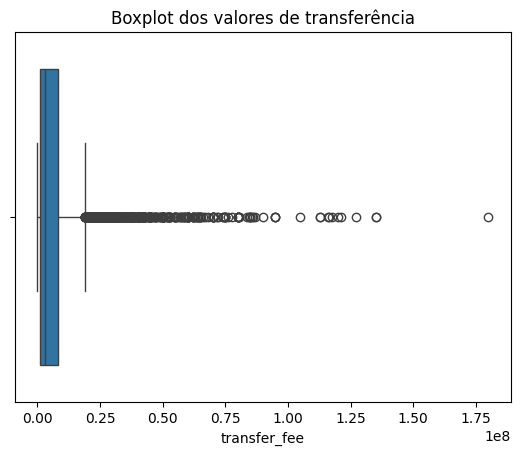

In [346]:
sns.boxplot(x=df['transfer_fee'])
plt.title('Boxplot dos valores de transferência')
plt.show()

In [347]:
# Remoção de outliers

q3 = df['transfer_fee'].quantile(0.75)
df_menor_valor = df[df['transfer_fee'] <= q3]


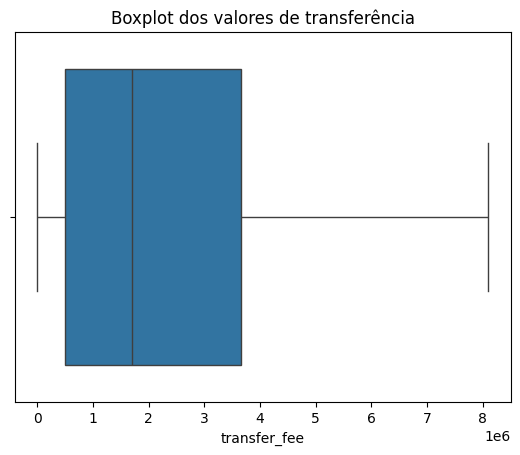

In [348]:
# Novo Boxplot após remoção de outliers

sns.boxplot(x=df_menor_valor['transfer_fee'])
plt.title('Boxplot dos valores de transferência')
plt.show()

Foi elaborada uma matriz de correlação para ambos os cenários a implementar, com o objetivo de analisar a relação linear entre as variáveis presentes em cada um dos conjuntos de dados. Esta análise permite identificar quais os atributos que apresentam maior correlação com a variável alvo (`transfer_fee`) e avaliar possíveis situações de multicolinearidade entre variáveis explicativas.

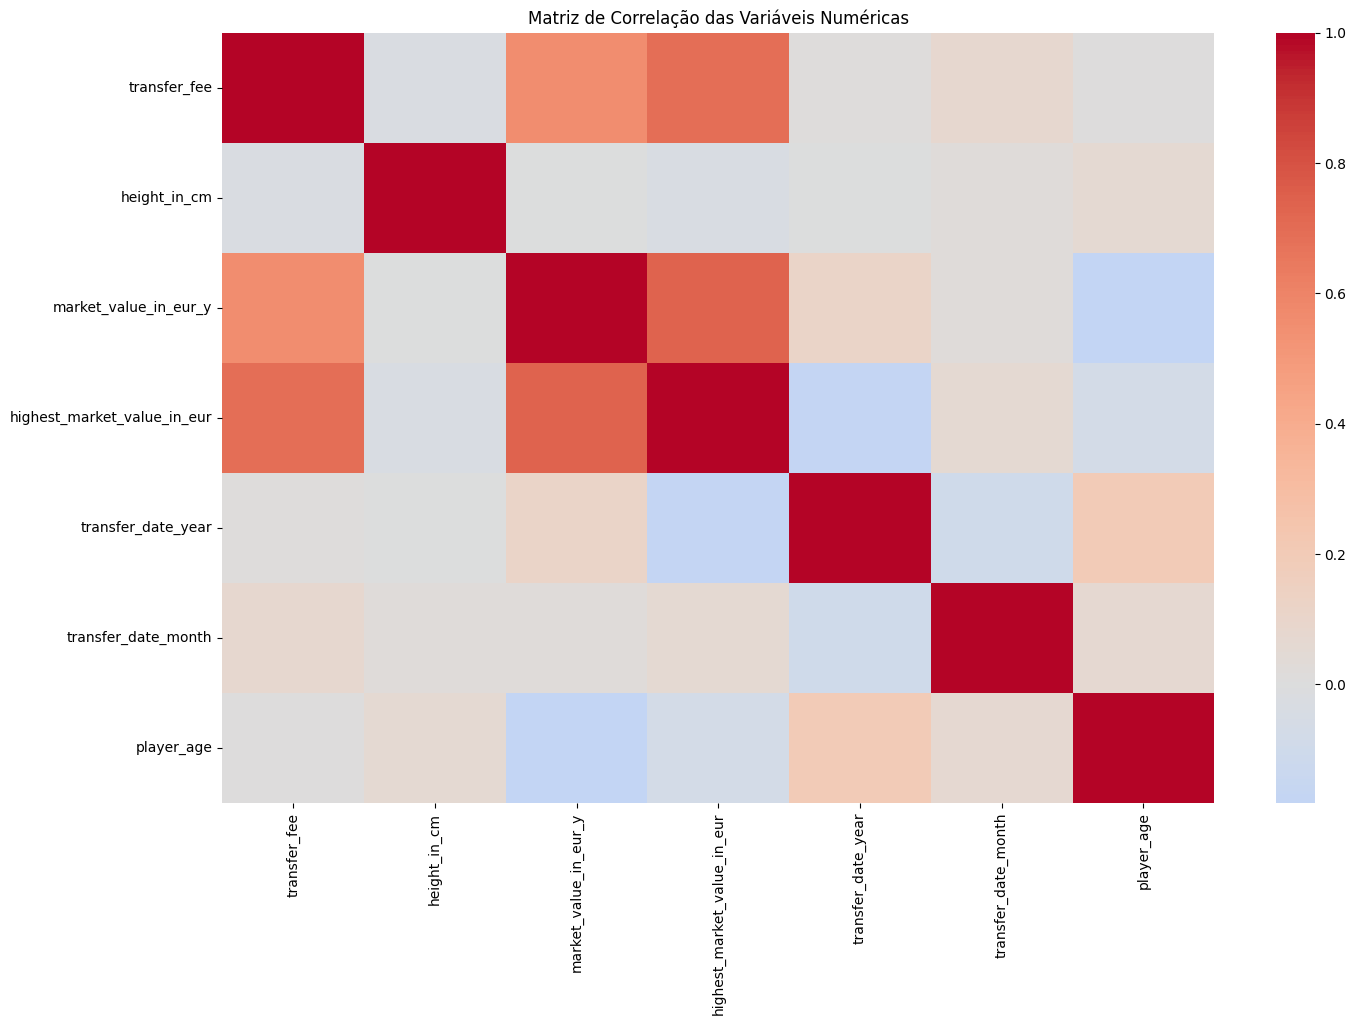

In [349]:
# Cenário 1

df_without_clubs = df.drop(columns=['squad_size_to', 'average_age_to','foreigners_percentage_to','national_team_players_to','net_transfer_record_to'])
# Calcular a matriz de correlação
corr_matrix = df_without_clubs.corr(numeric_only=True)

# Plot com seaborn
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


A análise da matriz de correlação para o primeiro cenário revela que as variáveis com maior associação linear ao valor de transferência (`transfer_fee`) são o valor de mercado atual (`market_value_in_eur_y`) e o valor de mercado mais elevado registado (`highest_market_value_in_eur`). Esta relação é esperada, uma vez que ambos os indicadores refletem diretamente a valorização do jogador no mercado. As restantes variáveis numéricas, como altura, idade, ano e mês de transferência, apresentam uma correlação bastante fraca com o target, sugerindo que têm um contributo limitado na explicação direta do valor de transferência. Ainda assim, podem conter alguma informação complementar útil quando combinadas com variáveis categóricas ou não lineares.


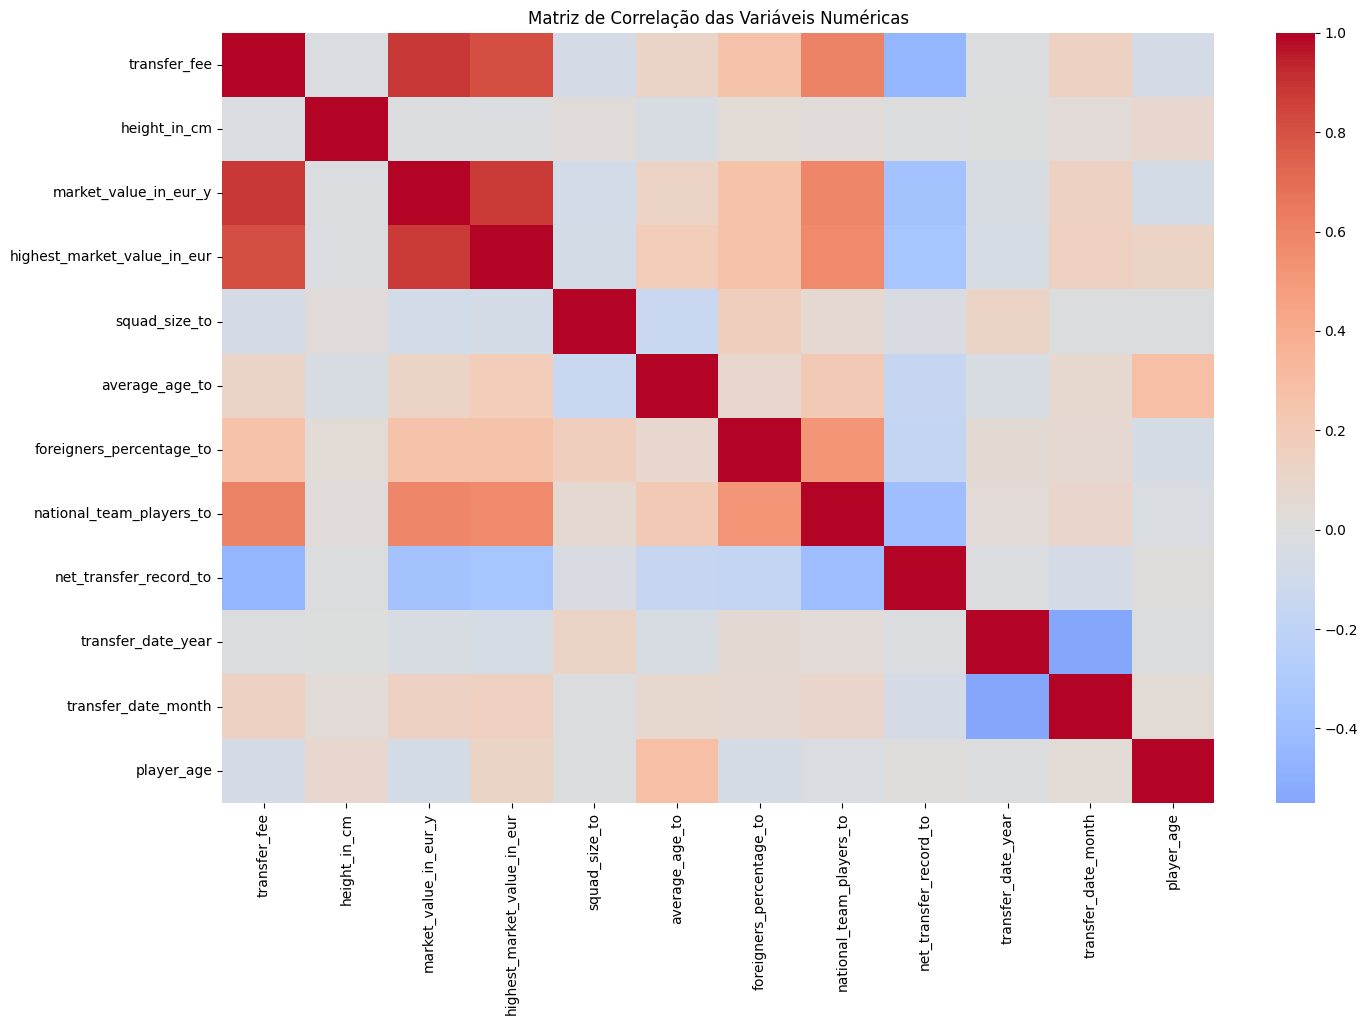

In [350]:
# Cenário 2

df_with_clubs = df[df['transfer_date_year'] >= 2024]
corr_matrix = df_with_clubs.corr(numeric_only=True)

# Plot com seaborn
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


A matriz de correlação para o segundo cenário, que inclui variáveis relacionadas com o clube comprador, confirma que as variáveis com maior associação ao valor de transferência (`transfer_fee`) continuam a ser o valor de mercado atual (`market_value_in_eur_y`) e o valor de mercado mais elevado (`highest_market_value_in_eur`). Este padrão já se verificava no primeiro cenário e reforça a ideia de que a valorização de mercado do jogador é o principal fator determinante no valor pago pela sua transferência.

As novas variáveis introduzidas neste cenário, como `national_team_players_to`, `foreigners_percentage_to` e `squad_size_to`, apresentam correlações positivas, ainda que moderadas, com o valor da transferência. Isto sugere que clubes com plantéis mais fortes, mais internacionais ou mais numerosos podem estar dispostos a investir mais em novos jogadores. Apesar de estas correlações não serem muito elevadas, estas variáveis podem conter valor preditivo adicional.

Em contraste, variáveis como `net_transfer_record_to`, `transfer_date_year` e `player_age` demonstram correlações muito fracas (ou mesmo negativas) com o valor da transferência. Isto indica que, quando analisadas isoladamente, têm um impacto reduzido na explicação da variável dependente.

A estrutura atual do conjunto de dados é adequada para avançar para a fase de modelação, sem necessidade de remoção de variáveis. As novas variáveis introduzidas no segundo cenário enriquecem o modelo com mais contexto, especialmente sobre o perfil dos clubes compradores.


Foi aplicada codificação One-Hot às variáveis categóricas `position`, `sub_position`, `foot` e `domestic_competition_id_to`, de forma a converter essas categorias em variáveis binárias. Esta transformação é essencial para permitir que os modelos de regressão interpretem corretamente dados categóricos.


In [353]:
from sklearn.preprocessing import OneHotEncoder

# Lista das variáveis categóricas a codificar
cat_vars = ['position', 'sub_position', 'foot', 'domestic_competition_id_to']

def encode_categoricals(df, cat_vars):
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    dummies = ohe.fit_transform(df[cat_vars])
    col_names = ohe.get_feature_names_out(cat_vars)
    cat_df = pd.DataFrame(dummies, columns=col_names, index=df.index)
    df = df.drop(columns=cat_vars)
    return pd.concat([df, cat_df], axis=1)

df_with_clubs = encode_categoricals(df_with_clubs, cat_vars)
df_without_clubs = encode_categoricals(df_without_clubs, cat_vars)


Foi aplicado o Min-Max Scaling às variáveis numéricas do conjunto de dados, transformando os seus valores para o intervalo [0, 1]. Esta normalização é particularmente importante para modelos de regressão, garantindo que todas as variáveis contribuem de forma proporcional para o modelo e evitando que variáveis com escalas superiores dominem a aprendizagem.


In [354]:
from sklearn.preprocessing import MinMaxScaler

# Listas de variáveis numéricas para cada cenário
num_vars_clubs = ['height_in_cm', 'market_value_in_eur_y', 'highest_market_value_in_eur',
                  'squad_size_to', 'average_age_to', 'foreigners_percentage_to',
                  'national_team_players_to', 'transfer_date_year',
                  'transfer_date_month', 'player_age', 'net_transfer_record_to']

num_vars_without_clubs = ['height_in_cm', 'market_value_in_eur_y', 'highest_market_value_in_eur',
                          'transfer_date_year', 'transfer_date_month', 'player_age']

# Função para aplicar MinMaxScaler de forma segura
def apply_minmax(df, num_vars):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[num_vars])
    scaled_df = pd.DataFrame(scaled_data, columns=num_vars, index=df.index)
    df[num_vars] = scaled_df[num_vars]
    return df

# Aplicar escalonamento corretamente aos dois DataFrames
df_with_clubs = apply_minmax(df_with_clubs, num_vars_clubs)
df_without_clubs = apply_minmax(df_without_clubs, num_vars_without_clubs)


Criei uma função genérica para separar o conjunto de dados em variáveis independentes (`X`) e variável dependente (`y`), seguida da divisão entre treino e teste utilizando a função `train_test_split` do `scikit-learn`, com 70% dos dados para treino e 30% para teste.

Esta operação foi aplicada de forma independente aos dois cenários (com e sem variáveis dos clubes), garantindo que cada modelo é treinado e avaliado de forma isolada e consistente.


In [355]:
from sklearn.model_selection import train_test_split

def split_features_target(df, target='transfer_fee', test_size=0.3, random_state=0, nome=''):

    X = df.drop(columns=target)
    y = df[target].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    print(f"Cenário {nome}:")
    print(f"  Conjunto de treino: {X_train.shape[0]} linhas")
    print(f"  Conjunto de teste:  {X_test.shape[0]} linhas\n")

    return X_train, X_test, y_train, y_test

X_train_clubs, X_test_clubs, y_train_clubs, y_test_clubs = split_features_target(
    df_with_clubs, nome='com clubes')

X_train_no_clubs, X_test_no_clubs, y_train_no_clubs, y_test_no_clubs = split_features_target(
    df_without_clubs, nome='sem clubes')

Cenário com clubes:
  Conjunto de treino: 911 linhas
  Conjunto de teste:  391 linhas

Cenário sem clubes:
  Conjunto de treino: 5322 linhas
  Conjunto de teste:  2281 linhas



Defini uma função para treinar um modelo de regressão linear. A função recebe os conjuntos de treino (`X_train` e `y_train`) e ajusta o modelo aos dados. De seguida treinei dois modelos com os dados dos 2 cenários que pretendia experimentar.

In [356]:
from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

model_clubs = train_linear_regression(X_train_clubs, y_train_clubs)
model_no_clubs = train_linear_regression(X_train_no_clubs, y_train_no_clubs)


O passo seguinte consiste em realizar as previsões.

In [357]:
predictions_clubs = model_clubs.predict(X_test_clubs)
predictions_no_clubs = model_no_clubs.predict(X_test_no_clubs)

Por fim passamos ao cálculo das métricas.

In [358]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, nome=''):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f'Avaliação do modelo {nome}')
    print(f'  MSE : {mse:.2f}')
    print(f'  RMSE: {rmse:.2f}')
    print(f'  R²  : {r2:.4f}\n')

evaluate_model(y_test_clubs, predictions_clubs, nome='com clubes')
evaluate_model(y_test_no_clubs, predictions_no_clubs, nome='sem clubes')

Avaliação do modelo com clubes
  MSE : 18429375796795.17
  RMSE: 4292944.89
  R²  : 0.8414

Avaliação do modelo sem clubes
  MSE : 60710460605698.75
  RMSE: 7791691.77
  R²  : 0.5358



### Avaliação e Comparação dos Modelos

Foram avaliados dois modelos de regressão linear: um com base apenas nas características do jogador e da transferência, e outro que integra também variáveis relacionadas com o clube comprador. A avaliação foi feita com base em três métricas principais: **MSE (Erro Quadrático Médio)**, **RMSE (Raiz do Erro Quadrático Médio)** e **R² (Coeficiente de Determinação)**.

Estes resultados demonstram de forma clara que **a inclusão das variáveis do clube comprador melhora significativamente o desempenho do modelo**. O erro médio das previsões (RMSE) é reduzido em mais de **3 milhões de euros**, e o modelo com clubes é capaz de explicar **84% da variabilidade no valor da transferência**, face a apenas **53%** no modelo sem contexto de clube.

O modelo com clubes consegue captar melhor a realidade do mercado de transferências, uma vez que inclui informação crítica como:
- Tamanho do plantel do clube comprador;
- Percentagem de jogadores estrangeiros;
- Número de internacionais

Estas variáveis ajudam a caracterizar a capacidade financeira e o perfil de contratação dos clubes, o que permite ao modelo ajustar as previsões de forma mais informada.

### Limitações e contexto de aplicação

Importa referir que, para este estudo, foram **removidos os outliers** (transferências com valores muito elevados), restringindo o modelo a um universo de transferências **mais modestas e realistas**, como é típico em clubes de média ou pequena dimensão. Este modelo é, portanto, mais adequado para contextos onde **o objetivo é estimar valores de mercado para transações comuns**, não para grandes transferências excecionais de mercado.

Além disso, sendo este um modelo de **regressão linear**, assume uma relação linear entre as variáveis independentes e o valor da transferência. Este tipo de modelo não é capaz de captar interações complexas ou relações não lineares entre variáveis — o que pode limitar a sua capacidade de previsão em situações com comportamentos mais dinâmicos do mercado.

### Conclusão

O modelo com clubes mostra-se **mais robusto e fiável** para prever o valor de transferências de jogadores em contextos realistas. A ausência de variáveis contextuais no segundo modelo resulta num desempenho significativamente inferior, o que valida a importância de incluir fatores relacionados com o poder de compra e o perfil competitivo dos clubes compradores.